# Natural Gradient Optimization of CHSH Nonlocality

In this notebook, the quantum natural gradient is used to maximize nonlocality in the CHSH scenario. 
The quantum natural gradient is a hardware-compatabile gradient optimization technique.
For more details please refer to https://arxiv.org/abs/1909.02108 and this [PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_quantum_natural_gradient.html).

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from context import qnetvo as QNopt

The CHSH scenario is a simple Bipartite scenario

<div>
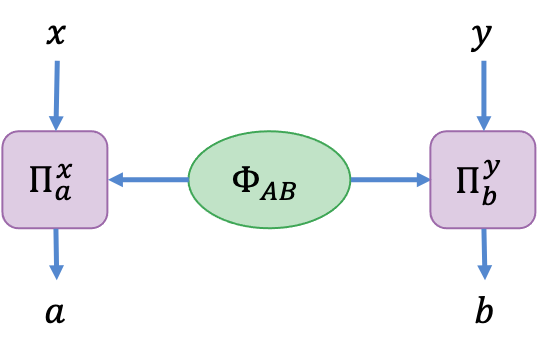
</div>
    
<!-- <img src="images/chsh_scenario.png" alt="chsh scenario" width="200"/> -->

We will perform the natural gradient for both real and general state/measurent parameterizations of this scenario.

In [2]:
def bell_state_RY(settings, wires):
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    
    qml.RY(settings[0], wires=wires[0])
    qml.RY(settings[1], wires=wires[1])

RY_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], bell_state_RY, 2)
]
RY_meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], QNopt.local_RY, 1),
    QNopt.MeasureNode(2, 2, [1], QNopt.local_RY, 1),
]

real_chsh_ansatz = QNopt.NetworkAnsatz(RY_prep_nodes, RY_meas_nodes)

arb_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]
arb_meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(2, 2, [1], qml.templates.subroutines.ArbitraryUnitary, 3),
]

arb_chsh_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, arb_meas_nodes)

real_chsh_cost = QNopt.chsh_inequality_cost(real_chsh_ansatz)
arb_chsh_cost = QNopt.chsh_inequality_cost(arb_chsh_ansatz)

real_chsh_ng = QNopt.chsh_natural_grad(real_chsh_ansatz)
arb_chsh_ng = QNopt.chsh_natural_grad(arb_chsh_ansatz)

## Optimizing CHSH Nonlocality with Natural Gradient

Now we compare the natural gradient with backpropagation for both real and general CHSH scenario parameterizations.

### Real CHSH Parameterization

In [3]:
np.random.seed(99)
real_settings = real_chsh_ansatz.rand_scenario_settings()

real_ng_opt_dict = QNopt.gradient_descent(
    real_chsh_cost,
    real_settings,
    sample_width=1,
    step_size=0.01,
    num_steps=20,
    verbose=False,
    grad_fn=real_chsh_ng
)

real_bp_opt_dict = QNopt.gradient_descent(
    real_chsh_cost,
    real_settings,
    sample_width=1,
    step_size=0.01,
    verbose=False,
    num_steps=20
)

real_bp_opt_dict2 = QNopt.gradient_descent(
    real_chsh_cost,
    real_settings,
    sample_width=1,
    step_size=0.1,
    verbose=False,
    num_steps=20
)

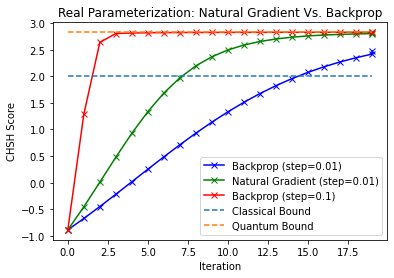

In [4]:
# Plot the score of the CHSH Bell inequality
plt.plot(real_bp_opt_dict["samples"], real_bp_opt_dict["scores"], "bx-", label = "Backprop (step=0.01)")
plt.plot(real_ng_opt_dict["samples"], real_ng_opt_dict["scores"], "gx-", label = "Natural Gradient (step=0.01)")
plt.plot(real_bp_opt_dict2["samples"], real_bp_opt_dict2["scores"],"rx-", label = "Backprop (step=0.1)")
plt.plot(real_bp_opt_dict["samples"], [2]*len(real_bp_opt_dict["samples"]), "--", label = "Classical Bound")
plt.plot(real_bp_opt_dict["samples"], [2*np.sqrt(2)]*len(real_bp_opt_dict["samples"]), "--", label = "Quantum Bound")
plt.title("Real Parameterization: Natural Gradient Vs. Backprop")
plt.xlabel("Iteration")
plt.ylabel("CHSH Score")
plt.legend()
plt.show()

### General CHSH Parameterization

In [5]:
np.random.seed(99)
arb_settings = arb_chsh_ansatz.rand_scenario_settings()

ng_arb_opt_dict = QNopt.gradient_descent(
    arb_chsh_cost,
    arb_settings,
    sample_width=1,
    step_size=0.05,
    verbose=False,
    num_steps=20,
    grad_fn=arb_chsh_ng
)

bp_arb_opt_dict = QNopt.gradient_descent(
    arb_chsh_cost,
    arb_settings,
    sample_width=1,
    step_size=0.05,
    verbose=False,
    num_steps=20
)

bp_arb_opt_dict2 = QNopt.gradient_descent(
    arb_chsh_cost,
    arb_settings,
    sample_width=1,
    step_size=0.2,
    verbose=False,
    num_steps=20
)

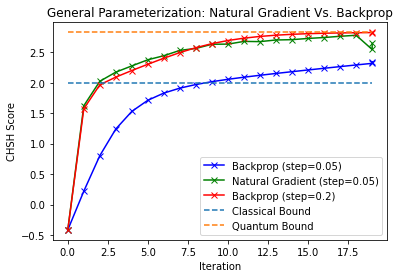

In [6]:
# Plot the score of the CHSH Bell inequality
plt.plot(bp_arb_opt_dict["samples"], bp_arb_opt_dict["scores"], "bx-", label = "Backprop (step=0.05)")
plt.plot(ng_arb_opt_dict["samples"], ng_arb_opt_dict["scores"], "gx-", label = "Natural Gradient (step=0.05)")
plt.plot(bp_arb_opt_dict2["samples"], bp_arb_opt_dict2["scores"], "rx-", label = "Backprop (step=0.2)")
plt.plot(bp_arb_opt_dict["samples"], [2]*len(bp_arb_opt_dict["samples"]), "--", label = "Classical Bound")
plt.plot(bp_arb_opt_dict["samples"], [2*np.sqrt(2)]*len(bp_arb_opt_dict["samples"]), "--", label = "Quantum Bound")
plt.title(r"General Parameterization: Natural Gradient Vs. Backprop")
plt.xlabel("Iteration")
plt.ylabel(r"CHSH Score")
plt.legend()
plt.show()